<a href="https://colab.research.google.com/github/KnowledgeEdgeAI/PETs_for_Public_Health_Challenge/blob/main/learnConsumptionDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv(r"/content/drive/MyDrive/technical_phase_data.csv")

In [4]:
def categorize_city(code):
    if code.startswith("5"):
        return "Medellin"
    elif code.startswith("11"):
        return "Bogota"
    elif code.startswith("70"):
        return "Brasilia"
    else:
        return "Santiago"

In [5]:
# Apply the categorize_city function to create a new 'city' column
data['city'] = data['merch_postal_code'].astype(str).apply(categorize_city)

# Group by 'city' and 'merch_category', then sum the 'nb_transactions' column
city_category_transaction_sum = data.groupby(['city', 'merch_category'])['nb_transactions'].sum().unstack(fill_value=0)

print(city_category_transaction_sum)
city_category_transaction_array = city_category_transaction_sum.values
print(city_category_transaction_array)

merch_category  Airlines  Bars/Discotheques  \
city                                          
Bogota            551687            9946925   
Brasilia          194221            3203856   
Medellin          345942            6046291   
Santiago          185165            3668468   

merch_category  Computer Network/Information Services  Drug Stores/Pharmacies  \
city                                                                            
Bogota                                        4748509                64362333   
Brasilia                                      1879233                26739076   
Medellin                                      2704070                38379292   
Santiago                                      1840230                23949367   

merch_category  General Retail Stores  Grocery Stores/Supermarkets  Hospitals  \
city                                                                            
Bogota                       18894258                     41252506  

In [6]:
contact_others = pd.read_csv('/content/drive/MyDrive/contact_others.csv')

In [7]:
import numpy as np

In [8]:
contact_others = np.array(contact_others)

## Estimating with tensorflow (which does the backpropogation based on the flow graph)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assume city_category_transaction_array and contact_others are already defined
N = city_category_transaction_array
num_cities = N.shape[0]
num_merch_categories = N.shape[1]
num_age_bins = 16
P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector

epsilon = 1e-10  # Small value to avoid division by zero

# Create TensorFlow variables for W with shape (num_merch_categories, num_age_bins)
W = tf.Variable(np.random.rand(num_merch_categories, num_age_bins), dtype=tf.float32)
row_sums = tf.reduce_sum(W, axis=1, keepdims=True)
W.assign(W / (row_sums + epsilon))

# Loss function based on residuals
def loss_fn():
    estimated_C = tf.zeros((num_age_bins, num_age_bins), dtype=tf.float32)
    for i1 in range(num_age_bins):
        for i2 in range(num_age_bins):
            total_sum = tf.reduce_sum([
                tf.reduce_sum([
                    (W[j, i1] * N[i, j] / (tf.reduce_sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                     (W[j, i2] * N[i, j] / (tf.reduce_sum(W[:, i1] * N[i]) + epsilon)) * P[i1]
                     for j in range(num_merch_categories)
                ]) / P[i2] for i in range(num_cities)
            ]) / num_cities
            estimated_C = estimated_C + tf.scatter_nd([[i1, i2]], [total_sum], shape=estimated_C.shape)

    residuals = estimated_C - contact_others
    return tf.reduce_sum(tf.square(residuals))

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
iteration_residuals = []

# Run the training loop on the GPU
with tf.device('/GPU:0'):
  for step in range(10000):  # Adjust max iterations as needed
      with tf.GradientTape() as tape:
          loss = loss_fn()
      grads = tape.gradient(loss, [W])

      # Apply gradients
      optimizer.apply_gradients(zip(grads, [W]))

      # Clip W to ensure it remains above epsilon
      W.assign(tf.clip_by_value(W, epsilon, tf.reduce_max(W)))
      row_sums = tf.reduce_sum(W, axis=1, keepdims=True)
      W.assign(W / (row_sums + epsilon))
      # Track and print progress
      iteration_residuals.append(loss.numpy())
      if step % 100 == 0:
          print(f'Step: {step}, Loss: {loss.numpy()}')

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()


Step: 0, Loss: 1417.8695068359375


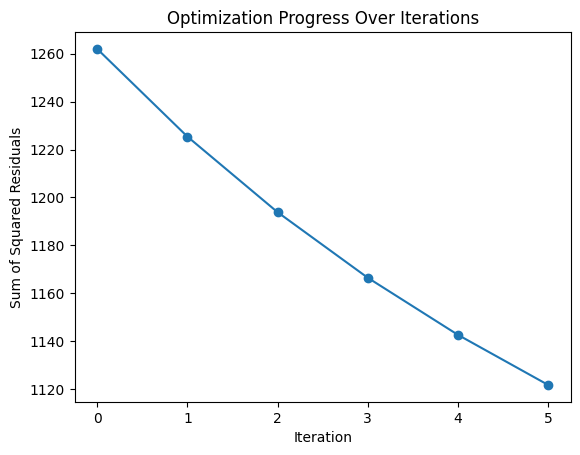

In [ ]:
# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()

## Estimating the weight matrix with scipy (doesn't allow changing the learning rate)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

N = city_category_transaction_array
num_cities = N.shape[0]
num_merch_categories = N.shape[1]
num_age_bins = 16
P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector

epsilon = 1e-6  # Small value to avoid division by zero

# Residuals function with W reshaped as num_merh_categories x num_age_bins
def residuals(W):
    W = W.reshape(num_merch_categories, num_age_bins)
    residuals = []
    for i1 in range(num_age_bins):
        for i2 in range(num_age_bins):
            estimated_C = sum(sum(
                (W[j, i1] * N[i][j] / (sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                (W[j, i2] * N[i][j] / (sum(W[:, i1] * N[i]) + epsilon )) * P[i1]
                for j in range(num_merch_categories)
            ) / P[i2] for i in range(num_cities))/ num_cities
            residuals.append(estimated_C - contact_others[i1, i2])
    return np.array(residuals)

# Constraint for row sum < 1
def row_sum_constraint(W):
    W = W.reshape(num_merch_categories, num_age_bins)
    return 1 - np.sum(W, axis=1)

# Additional bounds to ensure each W element is > 0
bounds = [(0, None) for _ in range(num_merch_categories * num_age_bins)]

# Capture the residual sums across iterations
iteration_residuals = []

# Callback function to capture progress during optimization
def callback(W):
    # Calculate and store the sum of squared residuals for plotting
    print(np.sum(residuals(W)))
    iteration_residuals.append(np.sum(residuals(W) ** 2))

# Initial guess
initial_W = np.random.rand(num_merch_categories, num_age_bins).flatten()

print(np.sum(residuals(initial_W)))
# Minimize with constraints and bounds
result = minimize(
    lambda W: np.sum(residuals(W)),  # Objective: minimize absolute residuals
    initial_W,
    constraints=[{'type': 'ineq', 'fun': row_sum_constraint}],
    bounds=bounds,
    method='SLSQP',
    callback=callback
)

# Reshape estimated W
W_estimated = result.x.reshape(num_merch_categories, num_age_bins)

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()


## Estimating the weight matrix with custom update (user written partial differential)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

N = city_category_transaction_array
num_cities = N.shape[0]
num_merch_categories = N.shape[1]
num_age_bins = 16
P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector

epsilon = 1e-10  # Small value to avoid division by zero


# Residuals function with W reshaped as num_merh_categories x num_age_bins
def residuals(W):
    W = W.reshape(num_merch_categories, num_age_bins)
    residuals = []
    for i1 in range(num_age_bins):
        for i2 in range(num_age_bins):
            estimated_C = sum(sum(
                (W[j, i1] * N[i][j] / (sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                (W[j, i2] * N[i][j] / (sum(W[:, i1] * N[i]) + epsilon)) * P[i1]
                for j in range(num_merch_categories)
            ) / P[i2] for i in range(num_cities)) / num_cities
            residuals.append(estimated_C - contact_others[i1, i2])
    return np.array(residuals)

## Calculating the grad of the sum of the square of each residual
def grad_residuals(W):
    W = W.reshape(num_merch_categories, num_age_bins)
    grad = np.zeros((num_merch_categories, num_age_bins))
    estimated_C = np.zeros_like(contact_others)
    for i1 in range(num_age_bins):
            for i2 in range(num_age_bins):
                estimated_C[i1][i2] = sum(sum(
                    (W[j, i1] * N[i][j] / (sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                    (W[j, i2] * N[i][j] / (sum(W[:, i1] * N[i]) + epsilon)) * P[i1]
                    for j in range(num_merch_categories)
                ) / P[i2] for i in range(num_cities)) / num_cities
    for a in range(num_merch_categories):
        for b in range(num_age_bins):
            for i1 in range(num_age_bins):
                for i2 in range(num_age_bins):
                    delta = estimated_C[i1][i2] - contact_others[i1, i2]
                    curr_grad =0
                    if b != i1 and b!=i2:
                        pass
                    elif b == i1 and b!=i2:
                        for i in range(num_cities):
                            curr_grad += ((N[i][a] * P[i2]) / (sum(W[:, i2] * N[i]) + epsilon)) - (P[i1]* N[i][a] * (sum(W[:,i2]*N[i]))) / ((sum(W[:,i1]*N[i]) + epsilon)**2)
                    elif b != i1 and b==i2:
                        for i in range(num_cities):
                            curr_grad += ((N[i][a] * P[i1]) / (sum(W[:, i1] * N[i]) + epsilon)) - (P[i2]* N[i][a] * (sum(W[:,i1]*N[i]))) / ((sum(W[:,i2]*N[i]) + epsilon)**2)
                    else:
                        for i in range(num_cities):
                            curr_grad += - (N[i][a] * P[i1])/(sum(W[:,i1]*N[i]) + epsilon)
                grad[a, b]+= curr_grad*delta
    return grad.flatten()



# Learning rate and momentum parameters
learning_rate = 0.1
momentum = 0.9

# Capture the residual sums across iterations
iteration_residuals = []


def optimize(W):
    W = W.copy()  # Avoid modifying input W
    v = np.zeros_like(W)  # Initialize momentum

    for _ in range(10000):  # Adjust max iterations as needed
        # Calculate gradient
        g = grad_residuals(W)
        # g= np.clip(g, -1, 1)

        # Update momentum
        v = momentum * v + learning_rate * g

        # Update weights
        W -= v
        # W = np.clip(W, epsilon, None)
        # W = np.maximum(W, epsilon)

        # Calculate and store loss for plotting
        iteration_residuals.append(np.sum(residuals(W) ** 2))
        # print loss every 100 iterations
        if _ % 100 == 0:
            print(f'Iteration: {_}, Loss: {iteration_residuals[-1]}')

    return W


initial_W = np.random.rand(num_merch_categories, num_age_bins).flatten()

W_opt = optimize(initial_W)

# Reshape estimated W
W_estimated = W_opt.reshape(num_merch_categories, num_age_bins)

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()

Iteration: 0, Loss: 2069674.6428352208


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assume city_category_transaction_array and contact_others are already defined
N = city_category_transaction_array
num_cities = N.shape[0]
num_merch_categories = N.shape[1]
num_age_bins = 16
P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector

epsilon = 1e-10  # Small value to avoid division by zero

# Create TensorFlow variables for W with shape (num_merch_categories, num_age_bins)
W = tf.Variable(np.random.rand(num_merch_categories, num_age_bins), dtype=tf.float32)

# Normalize each row in W by dividing by the sum of the row
row_sums = tf.reduce_sum(W, axis=1, keepdims=True)
W= W / (row_sums + epsilon)

# Loss function based on residuals
def loss_fn():
    estimated_C = tf.zeros((num_age_bins, num_age_bins), dtype=tf.float32)
    for i1 in range(num_age_bins):
        for i2 in range(num_age_bins):
            total_sum = tf.reduce_sum([
                tf.reduce_sum([
                    (W[j, i1] * N[i, j] / (tf.reduce_sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                    (W[j, i2] * N[i, j] / (tf.reduce_sum(W[:, i1] * N[i]) + epsilon)) * P[i1]
                    for j in range(num_merch_categories)
                ]) / P[i2] for i in range(num_cities)
            ]) / num_cities
            estimated_C = estimated_C + tf.scatter_nd([[i1, i2]], [total_sum], shape=estimated_C.shape)

    residuals = estimated_C - contact_others
    return tf.reduce_sum(tf.square(residuals))

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.07)

# Training loop
iteration_residuals = []

for step in range(100):  # Adjust max iterations as needed
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, [W])
    optimizer.apply_gradients(zip(grads, [W]))

    # Clip W to ensure it remains above epsilon
    W.assign(tf.clip_by_value(W, epsilon, tf.reduce_max(W)))

  # Normalize each row of W so that the row sum equals 1
    row_sums = tf.reduce_sum(W, axis=1, keepdims=True)
    W.assign(W / (row_sums + epsilon))  # Adding epsilon to avoid division by zero


    # Track and print progress
    iteration_residuals.append(loss.numpy())
    if step % 2 == 0:
        print(f'Step: {step}, Loss: {loss.numpy()}')

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_unique_id'

## Plotting the results

In [ ]:
def plot_difference(estimated_C, contact_others):
    # Calculate the difference between estimated_C and contact_others
    difference = estimated_C - contact_others

    # Plot the difference using a color range
    plt.figure(figsize=(10, 8))
    plt.imshow(difference, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Difference')
    plt.title('Difference between estimated_C and contact_others')
    plt.xlabel('Index i2')
    plt.ylabel('Index i1')
    plt.show()

### Check the difference between ground truth contact matrix and estimated contact matrix based on random Weight matrix, W

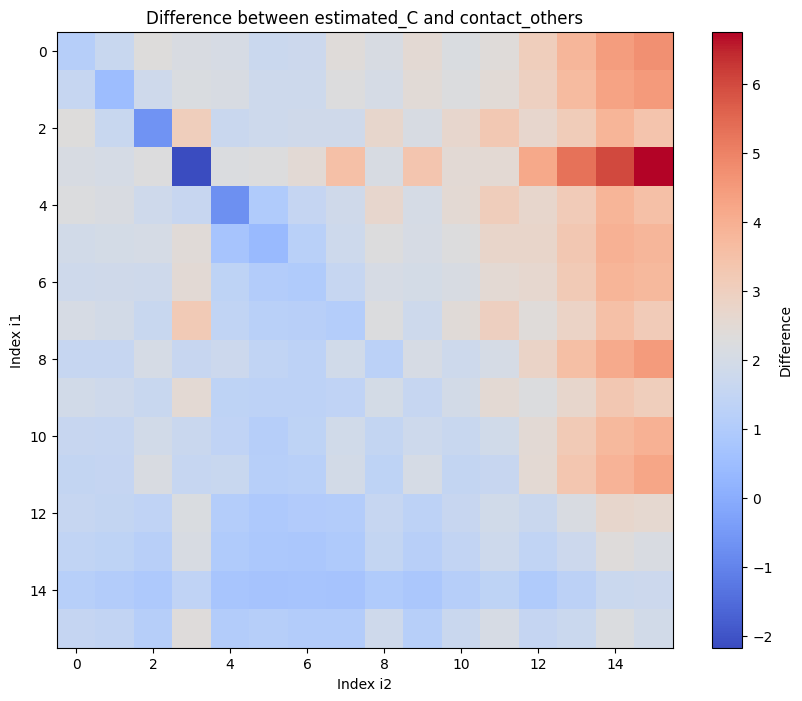

NameError: name 'residuals' is not defined

In [ ]:
W =np.random.rand(num_merch_categories, num_age_bins)
estimated_C = np.zeros((num_age_bins, num_age_bins))
for i1 in range(num_age_bins):
    for i2 in range(num_age_bins):
        estimated_C[i1, i2] = sum(sum(
                (W[j, i1] * N[i][j] / (sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                (W[j, i2] * N[i][j] / (sum(W[:, i1] * N[i]) + epsilon )) * P[i1]
                for j in range(num_merch_categories)
            ) / P[i2] for i in range(num_cities))/ num_cities

plot_difference(estimated_C, contact_others)
# print(np.sum(residuals(W) ** 2))

### Difference between ground truth and estimated one based on the optimal W

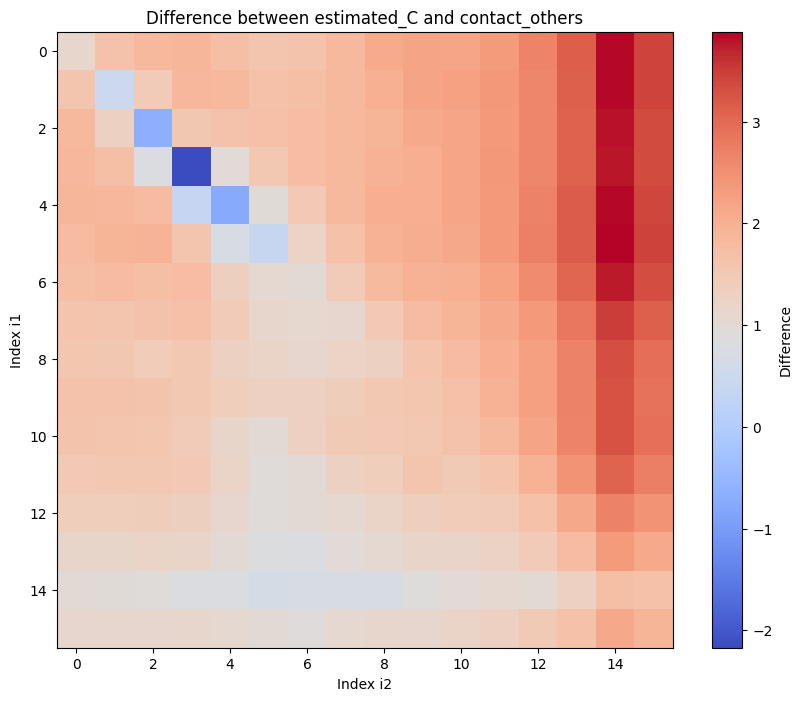

In [ ]:
# Calculate the estimated_C matrix based on the estimated W
estimated_C = np.zeros((num_age_bins, num_age_bins))
for i1 in range(num_age_bins):
    for i2 in range(num_age_bins):
        estimated_C[i1, i2] = sum(sum(
                (W[j, i1] * N[i][j] / (sum(W[:, i2] * N[i]) + epsilon)) * P[i2] +
                (W[j, i2] * N[i][j] / (sum(W[:, i1] * N[i]) + epsilon )) * P[i1]
                for j in range(num_merch_categories)
            ) / P[i2] for i in range(num_cities))/ num_cities



# Call the function with the estimated_C and contact_others
plot_difference(estimated_C, contact_others)

### Plotting W

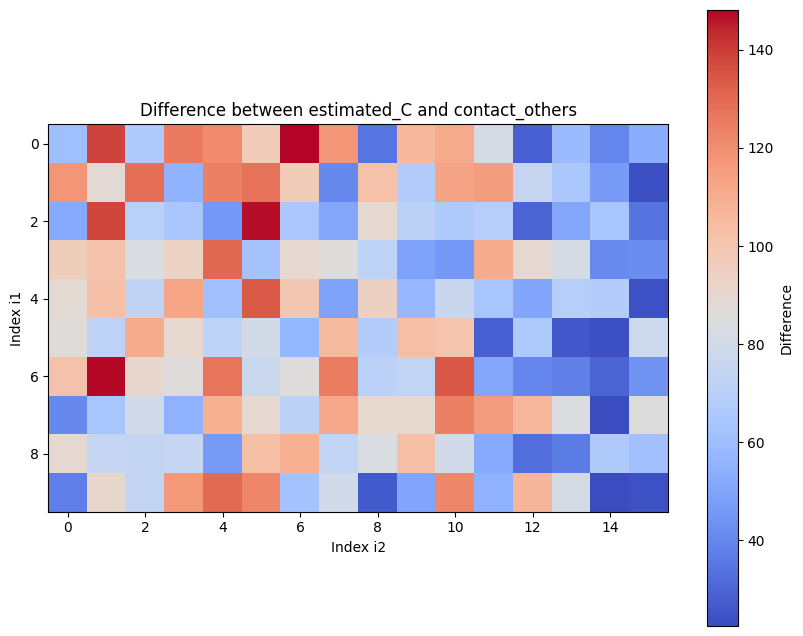

In [ ]:
plot_difference(W*100, np.zeros((num_merch_categories, num_age_bins)))

2.695105313076194e+33
1.25858390915318e+17
2.4581709388224116e+33
1.6782034022258847e+33
1501443726438709.5
3238083083325945.0
73745748794893.97
1.0893575622977482e+33
482573580174417.75
618456424498093.6
3.933011391093897e+33
804938148159697.6
2.0795442779760912e+33
8.834455264279214e+32
1.252969555771365e+16
4.616066925794768e+32
1.1428202145844064e+33
1.1173666611154177e+33
8.323001260138342e+32
3.812224575886191e+16
2.870338727134779e+32
6.21030266531316e+32
1.7658602185490186e+21
1.5052593706497516e+32
2.8814714365217475e+18
2.809525390073416e+32
1.7031660956481219e+18
9.206776052615392e+31
3.428461589240548e+17
2.4291901227505304e+19
979.1473507026699
5292.053212522854
986.105700920988
1003.9858058416625
971.9178573815424
970.0713151356857
969.9970025883074
970.1431600827715
970.1264287341354
970.0879471162393
969.9558824947611
969.952517361264
969.941800314582
969.9383258293855
969.937048088774
969.9359811088705
969.9343650172743
969.9327785296043
969.930835230683
969.9292257050

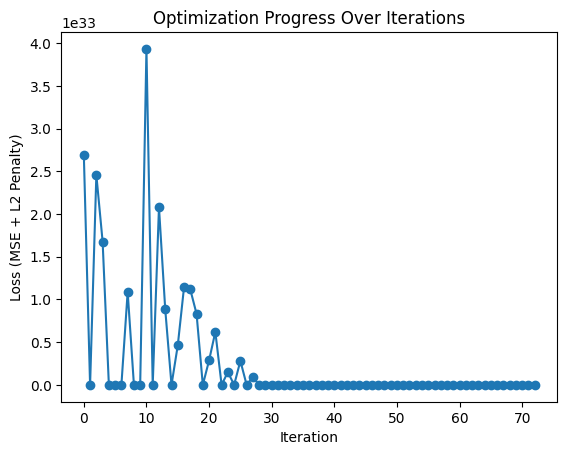

In [ ]:
# Small epsilon to avoid division by zero
epsilon = 1e-10

# Loss function with regularization
def loss_with_regularization(W, alpha=0.1):
    W = W.reshape(8, 16)
    residuals = []
    for i1 in range(16):
        for i2 in range(16):
            estimated_C = sum(
                (W[j, i1] * N[j] / (sum(W[:, i2] * N) + epsilon)) * P[i2] +
                (W[j, i2] * N[j] / (sum(W[:, i1] * N) + epsilon)) * P[i1]
                for j in range(8)
            ) / (P[i2] + epsilon)
            residuals.append(estimated_C - contact_others[i1, i2])
    mse = np.sum(np.array(residuals) ** 2)
    l2_penalty = alpha * np.sum(W ** 2)  # L2 regularization term
    return mse + l2_penalty

# Constraint: Each row in W should sum to <= 1
def row_sum_constraint(W):
    W = W.reshape(8, 16)
    return 1 - np.sum(W, axis=1)

# Bounds for W elements: ensure each W[i][j] > 0
bounds = [(0, None) for _ in range(8 * 16)]

# Initial guess
initial_W = np.random.rand(8, 16).flatten()

# Track the loss over iterations
iteration_losses = []

# Callback function to track loss at each iteration
def callback(W):
    current_loss = loss_with_regularization(W)
    print(current_loss)
    iteration_losses.append(current_loss)

# Minimize with constraints and bounds
result = minimize(
    loss_with_regularization,
    initial_W.flatten(),
    constraints={'type': 'ineq', 'fun': row_sum_constraint},
    bounds=bounds,
    method='SLSQP',
    callback=callback
)

# Reshape estimated W
W_estimated = result.x.reshape(8, 16)

# Plot the optimization progress
plt.plot(iteration_losses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE + L2 Penalty)')
plt.title('Optimization Progress Over Iterations')
plt.show()